#### Contexto: 
Você é um funcionário da OMS que tem que avaliar os níveis de contaminação de um vírus
em um determinado país. Todas as pessoas dentro de uma sociedade, estão conectadas de
alguma maneira (familia, amizade ou trabalho) e cada pessoa possui um conjunto de
atributos.

#### Objetivo:
Estimar a taxa para o restante dessa
sociedade.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.feature_selection import SelectFromModel

import utils

In [2]:
connections = pd.read_csv('./data/conexoes_espec.csv', sep=';')
individual = pd.read_csv('./data/individuos_espec.csv', sep=';')

## 1. Iniciação dos Dados
Entendendo a base de dados.

Realizar limpeza na base, verificar missing values e outliers. Em seguida, analisar o comportamento da variável resposta, além das caracteristicas dos indivíduos da população.

Antes disso, uma passada rápida por ambos os datasets.

Base "connections":

- Fazendo uma rápida prévia dos dados, observamos 5 variáveis: 

- V1 e V2 são os indivíduos conectados, junto a duas variáveis categóricas "grau" e "proximidade". 

- A variável "prob_V1_V2", nosso target, é contínua, com valores contidos no intervalo [0,1].

In [3]:
connections.dtypes

V1               int64
V2               int64
grau            object
proximidade     object
prob_V1_V2     float64
dtype: object

Base: "individual":

- Se apresenta com duas variáveis numéricas: "Idade" e "IMC".

- "Name" é a chave de identificação de cada indivíduo. As variáveis "estuda", "trabalha" e "pratica_esportes" são variáveis categoricas binárias, além do "estado_civil" e "transporte_mais_utilizado" que apresentam mais de uma categoria. 

- "qt_filhos" é uma variável ordinal que pode ser trabalhada como categoria também.

In [4]:
individual.dtypes

name                           int64
idade                        float64
estado_civil                  object
qt_filhos                    float64
estuda                       float64
trabalha                     float64
pratica_esportes             float64
transporte_mais_utilizado     object
IMC                          float64
dtype: object

### 1.1 Variável Target

A variável target é continua e, por ser um vetor de probabilidades, seu domínio está composto dentro do intervalo [0,1].

Por conta disso, temos um problema supervisionado de regressão. Estimar as taxas de contaminação para conexões dentro de uma população, levando em conta as características pessoais de ambos indivíduos.

Utilizaremos a função de custo RMSE, pois por serem probabilidades de infecção de uma doença sem cura, pequenos desvios podem até ser aceitaveis, mas uma predição muito errada pode ser catastrófica (penalização maior de discrepâncias muito grandes).

In [5]:
connections['prob_V1_V2'].describe()

count    499999.000000
mean          0.485162
std           0.173963
min           0.074462
25%           0.351677
50%           0.486413
75%           0.618210
max           0.942245
Name: prob_V1_V2, dtype: float64

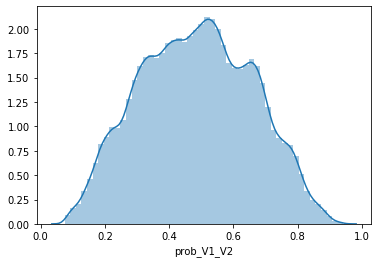

In [6]:
sns.distplot(connections['prob_V1_V2'])

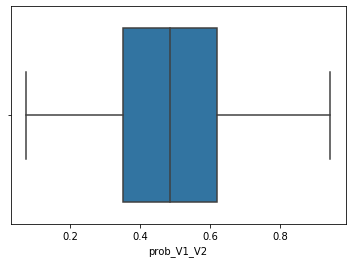

In [7]:
sns.boxplot(connections['prob_V1_V2'])

Como visualizado nas métricas e gráficos, a distribuição das probabilidades de contaminação não apresentam outliers e estão presentes em uma distribuição de sino (porém, não normal). Não observamos assimetrias acentuadas além de termos média e mediana similares.

Observa-se que 50% dos dados estão compreendidos no intervalo aproximado de 35% e 61% de probabilidade de contaminação.

Como a variável resposta possui missing values (por conta da natureza do Case), vamos prosseguir com sua separação para obtenção de um conjunto de teste.

In [8]:
df = connections[~connections['prob_V1_V2'].isnull()]

### 1.2 Missing Values

Mensurando a proporção dos missings em ambas as bases de dados para um maior entendimento da base de dados.

Text(0.5, 1.0, '% of Missings por Variavel: Base Individual')

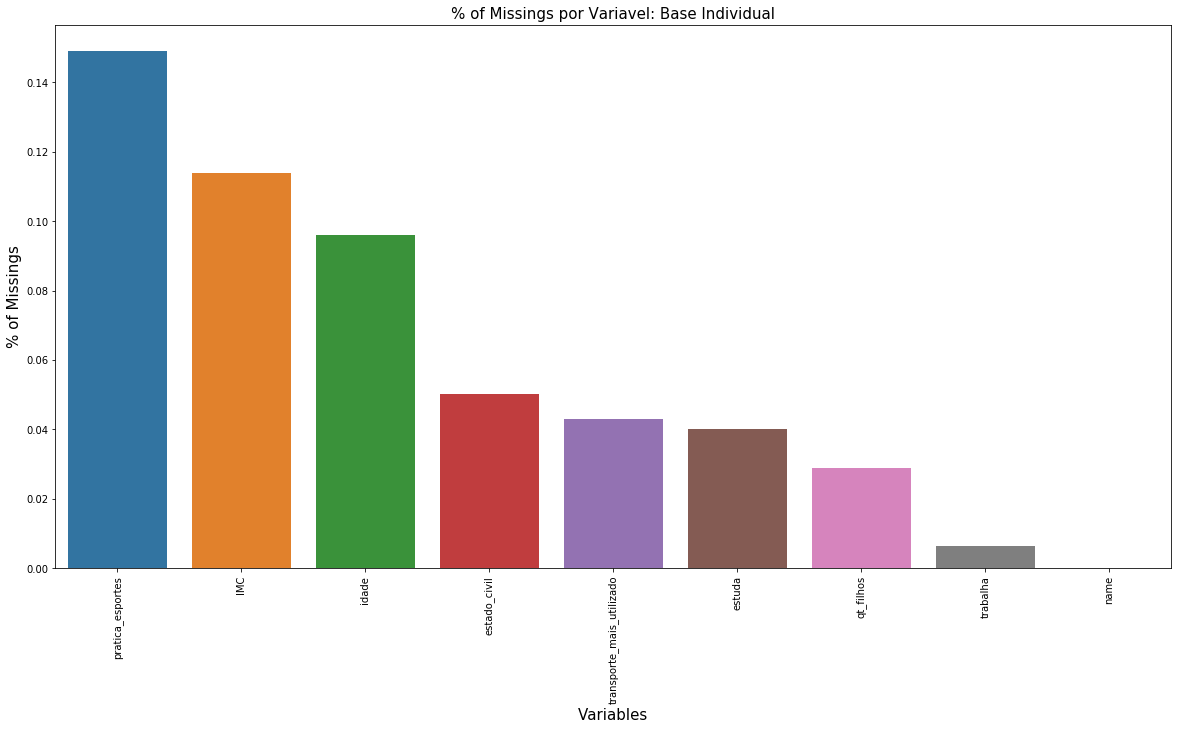

In [9]:
prop_missings = (individual.isna().sum().sort_values(ascending = False)/individual.shape[0])
f, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation = '90')
sns.barplot(x = prop_missings.index, y = prop_missings)
plt.xlabel('Variables', fontsize = 15)
plt.ylabel('% of Missings', fontsize = 15)
plt.title('% of Missings por Variavel: Base Individual', fontsize = 15)

Com excessão da variável "name", todas as outras apresentam alguma uma porcentagem de missing values. O intuito será trabalhar esses valores faltantes de alguma forma, evitando perda de informação e mantendo (o máximo possível) a qualidade dos dados.

Além disso, os missings não tratados na base "individual" vão estar presentes no dataset de estimação a ser enviado no final da atividade, causando problemas para realizar predições. Consequência disso é que nenhuma linha pode ser excluída desse exercício.

Obs: Apenas a variável "prob_V1_V2" do dataset "connections" tinha missings, dado a natureza do problema proposto.

#### 1.2.1 Recodando as Variáveis Categóricas

In [10]:
# Existem muitas categorias dentro de "qt_filhos". Cerca de 40% são de pessoas que não tem filhos. 
individual['qt_filhos'].value_counts()

0.0    401401
1.0    331186
2.0    166111
3.0     55410
4.0     13770
5.0      2716
6.0       476
7.0        53
8.0         9
9.0         1
Name: qt_filhos, dtype: int64

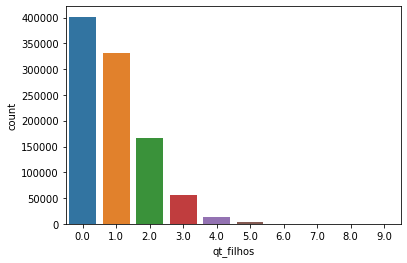

In [11]:
sns.countplot(individual['qt_filhos'])

In [12]:
# Recodando a variável, obtemos três categorias: Se tem filhos, se não tem, e os missings tratados como "sem_info".

individual['filhos_status'] = np.where(individual['qt_filhos']==0, 'sem_filhos',
                               np.where(individual['qt_filhos']>0, 'filhos', 'sem_info_filhos'))

individual.drop('qt_filhos', axis=1, inplace=True) 

In [13]:
# Variáveis Categóricas Não Binárias podem ser preenchidas com "sem_info".

to_fillna = individual.select_dtypes(include='object').columns # Variáveis Categóricas Não Binárias.

for column in to_fillna:
    individual[column].fillna('sem_info_' + column, inplace=True)
    


In [14]:
# Refatorando variáveis binárias.

individual['estuda'] = np.where(individual['estuda']==0, 'nao_estuda',
                               np.where(individual['estuda']==1, 'estuda', 'sem_info_estuda'))

individual['trabalha'] = np.where(individual['trabalha']==0, 'nao_trabalha',
                               np.where(individual['trabalha']==1, 'trabalha', 'sem_info_trabalha'))

individual['pratica_esportes'] = np.where(individual['pratica_esportes']==0, 'nao_pratica_esportes',
                               np.where(individual['pratica_esportes']==1, 'pratica_esportes', 'sem_info_pratica_esportes'))



#### 1.2.2 Imputação nas Variáveis Numéricas

Antes da imputação, vamos observar a distribuição das variáveis "Idade" e "IMC".

Text(0.5, 1.0, 'Idade: IMC')

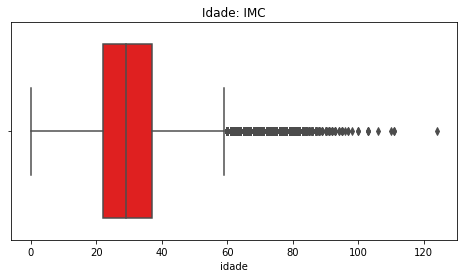

In [15]:
# Idade 
a4_dims = (8, 4)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(individual['idade'], color='red').set_title('Idade: IMC')

In [16]:
individual['idade'].describe()

count    904063.000000
mean         30.008431
std          10.951566
min           0.000000
25%          22.000000
50%          29.000000
75%          37.000000
max         124.000000
Name: idade, dtype: float64

Text(0.5, 1.0, 'BoxPlot: IMC')

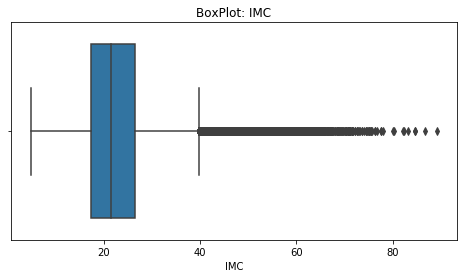

In [17]:
# IMC
a4_dims = (8, 4)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(individual['IMC']).set_title('BoxPlot: IMC')

In [18]:
individual['IMC'].describe()

count    886130.000000
mean         22.472079
std           7.073692
min           4.852828
25%          17.420851
50%          21.431200
75%          26.378197
max          89.158204
Name: IMC, dtype: float64

Ambas as variáveis possuem uma quantidade bastante inflada de outliers (alias, IMC acima de 40 já é considerado Obesidade Mórbida, e temos indivíduos com 70+). Um método de imputação seria pela mediana dessas quantidades, uma vez que esta é robusta a outliers dentro de uma distribuição (apesar de observarmos que em ambos os casos, a média está bem próxima da mediana, vamos seguir com a mediana por conta dessa justificativa).

In [19]:
individual['IMC'].fillna(individual['IMC'].median(), inplace=True)
individual['idade'].fillna(individual['idade'].median(), inplace=True)

Com isso, terminamos a etapa de missing values.

### 2. Sobre Outliers

Como vimos acima, variáveis númericas apresentam outliers que podem inflar as estimações do nosso futuro modelo: Idades elevadas e IMC's totalmente incondizente com a relidade.

Como mencionado anteriormente, nenhuma linha pode ser excluida desse dataset apesar de Idade e IMC conter outliers agressivos. Como menção honrosa, uma maneira interessante para detecção e exclusão destes, seria pela métrica do z-score: Transformando as variáveis numa distribuição N(0,1) e removendo observações que estejam 3 desvio padrões de distância da média.

Utilizando as faixas de IMC para categorizar a variável. As faixas utilizadas foram retiradas do site: https://pt.wikipedia.org/wiki/%C3%8Dndice_de_massa_corporal#Tabela_de_IMC

As faixas de idade são as usuais praticadas em campanhas de marketing por exemplo.

In [20]:
individual['status_IMC'] = np.where(individual['IMC']<17, 'muito_abaixo',
                               np.where((individual['IMC']>=17) & (individual['IMC']<18.5), 'abaixo',
                                        np.where((individual['IMC']>=18.5)&(individual['IMC']<25), 'adequado',
                                                 np.where((individual['IMC']>=25)&(individual['IMC']<30), 'acima',
                                                         np.where((individual['IMC']>=30)&(individual['IMC']<35), 'obesidade_I',
                                                                   np.where((individual['IMC']>=35)&(individual['IMC']<40), 'obesidade_II',
                                                                            np.where((individual['IMC']>=40), 'obsidade_III','sem_info_imc')))))))

In [21]:
individual['faixa_etaria'] = np.where(individual['idade']<18, 'menor_18',
                               np.where((individual['idade']>=18) & (individual['idade']<25), '18_24_anos',
                                        np.where((individual['idade']>=25)&(individual['idade']<35), '25_34_anos',
                                                 np.where((individual['idade']>=35)&(individual['idade']<45), '35_44_anos',
                                                         np.where((individual['idade']>=45)&(individual['idade']<55), '45_54_anos',
                                                                   np.where((individual['idade']>=55)&(individual['idade']<65), '55_64_anos',
                                                                            np.where((individual['idade']>=65), 'maior_65','none')))))))

In [22]:
individual['faixa_etaria'].value_counts()

25_34_anos    417271
18_24_anos    200833
35_44_anos    187973
menor_18      102472
45_54_anos     68804
55_64_anos     18107
maior_65        4540
Name: faixa_etaria, dtype: int64

In [23]:
# Análise Outliers com z-score.

#individual['z_IMC'] = np.abs(stats.zscore(individual['IMC']))
#individual['z_idade'] = np.abs(stats.zscore(individual['idade']))

#individual = individual[(individual['z_IMC']<3) & (individual['z_IMC']>-3)]
#individual = individual[(individual['z_idade']<3) & (individual['z_idade']>-3)]

#individual.drop(['z_IMC', 'z_idade'], axis=1, inplace=True)

Aproveitando o estudo das variáveis, podemos também chegar por correlações entre elas. O ideal é que seja uma quantidade fraca para evitar multicolinearidade.

In [24]:
# Coeficiente de Corr. de Pearson entre Idade e IMC resulta num valor praticamente nulo, 
# apontando para não correlação linear entre ambas.

# O coeficiente explicita a ausência de correlação linear entre Idade e IMC.
corr = stats.pearsonr(individual['idade'], individual['IMC'])[0].round(4)
print('Coeficiente de Correlação de Pearson entre idade e IMC: {}'.format(corr))

individual.drop(['idade', 'IMC'], axis=1, inplace=True)

Coeficiente de Correlação de Pearson entre idade e IMC: -0.0003


### 3. Análise Descritiva

#### 3.1 Análise Gráfica

Utilizaremos essa seção para realizar validação de algumas hipóteses em relação ao problema em questão. Outras poderão ser validadas no estudo do modelo final.

Por se tratar de uma doença, podemos questionar a priori quais características um indíviduo tem que podem agravar ou não a transmissão ou contágio da doença.

O problema não especifica de qual o vírus é transmitido para outras pessoas (por vias aéreas como a gripe e o corona por exemplo), mas pelas variáveis, podemos ter uma ideia de que proximidade possa ser um fator agravante. Portanto:

- 1. Pessoas que se veêm com frequência podem ter uma taxa de contagio/transmissão maior.
- 2. Pessoas mais velhas podem ser mais propícias a serem contaminadas.
- 3. Pessoas com IMC muito alto ou muito baixo podem acarretar em contágio mais acentuado.
- 4. Pessoas que utilizam taxi ou transporte público podem ter uma probabilidade maior de transmissão/contágio que as outras.



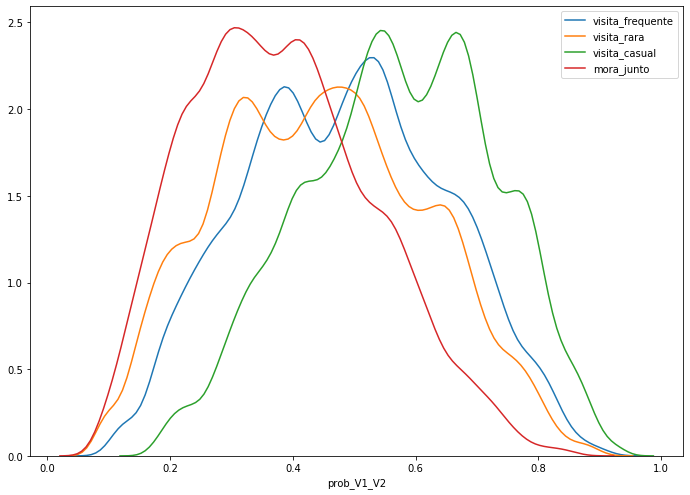

In [25]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

utils.plotting_categories(connections, 'proximidade')

As distribuições das categorias de proximidade em relação a taxa de contágio resulta em:

- Quem mora junto tem em média uma probabilidade de contágio muito menor do que quem se vê casualmente. Geralmente, o oposto seria a hipótese mais aceita.

- Visita Casual apresenta uma distribuição praticamente bimodal e é a que apresenta a maior concentração de taxas elevadas dentre as 4 categorias de proximidade.    

In [26]:
casual = df[df['proximidade']=='visita_casual']
mora_junto = df[df['proximidade']=='mora_junto']

In [27]:
casual['prob_V1_V2'].describe()

count    150365.000000
mean          0.571399
std           0.154709
min           0.163618
25%           0.460240
50%           0.574924
75%           0.686536
max           0.942245
Name: prob_V1_V2, dtype: float64

In [28]:
mora_junto['prob_V1_V2'].describe()

count    49891.000000
mean         0.382328
std          0.149380
min          0.074913
25%          0.268216
50%          0.371606
75%          0.483781
max          0.868571
Name: prob_V1_V2, dtype: float64

Em média, quem mora junto tem uma probabilidade de transmissão de 38%, enquanto quem se ve casualmente tem esse valor em 57% (detalhe que ambos possuem desvio padrão similiar). Portanto, a hipótese de contato com maior frequência influênciar na maior transmissão do virus não é tão valida, visto também o ranking das médias das proximidades (visita_casual > frequênte > rara > morar_junto).

Em seguida, temos a hipótese de que conexões de trabalho possam ter uma taxa maior do que amigos e familia, uma vez que essas conexões tendem a ter mais contato com diversas pessoas da empresa.

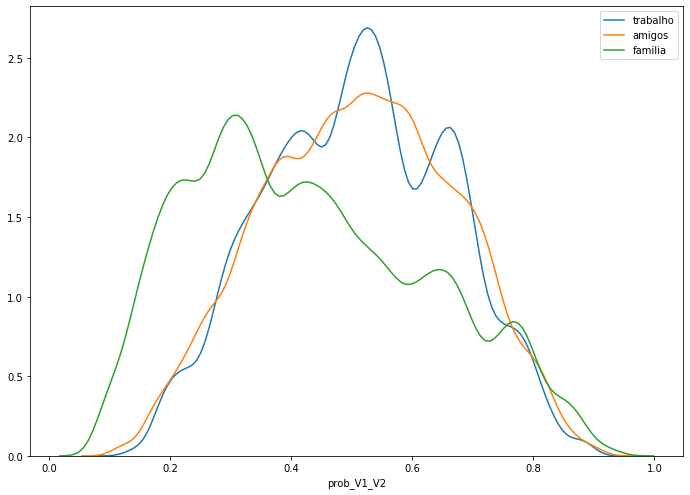

In [29]:
a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)

utils.plotting_categories(connections, 'grau')

As distribuições das categorias de proximidade em relação a taxa de contágio resulta em:

- Amigos e Trabalho tem taxas similares mas com formatos de distribuição diferentes.
- Conexões de família tem taxas de contagio menores se comparada aos outros dois grupos.

In [30]:
amigos = df[df['grau']=='amigos']
trabalho = df[df['grau']=='trabalho']
familia = df[df['grau']=='familia']

In [31]:
amigos['prob_V1_V2'].describe()

count    166437.000000
mean          0.512242
std           0.158313
min           0.099979
25%           0.393160
50%           0.515072
75%           0.629889
max           0.925766
Name: prob_V1_V2, dtype: float64

In [32]:
trabalho['prob_V1_V2'].describe()

count    166953.000000
mean          0.511592
std           0.152077
min           0.123167
25%           0.397271
50%           0.514113
75%           0.630288
max           0.907455
Name: prob_V1_V2, dtype: float64

In [33]:
familia['prob_V1_V2'].describe()

count    166609.000000
mean          0.431625
std           0.195729
min           0.074462
25%           0.276380
50%           0.407497
75%           0.576753
max           0.942245
Name: prob_V1_V2, dtype: float64

Vemos que trabalho e amigos tem distribuição muito similar, tanto que suas médias, mediana e desvio padrão estão muito próximos, ao contrário do grupo de família.

Por fim, podemos ver que esses dois grupos tem magnitudes bastante parecidos em relação a taxa de contaminação.

### Juntando os Datasets "individual" x "connections"

Vamos juntar os datasets em um só para o prosseguir com a análise e modelagem futura. O intuito é ter ambas características do individuo contaminado e do que foi contaminado numa linha só, e utilizar esses dados para ponderar qual combinação de variáveis influência na taxa de contaminação.

In [34]:
"""
 O intuito é abribuir as características de ambos V1 e V2 numa única linha.
 Para isso, duplicaremos o dataset "individual" e renomearemos suas categorias e colunas para que as informações 
 estejam devidamente claras. 
"""

ind_V1 = individual.copy()
ind_V2 = individual.copy()

to_categorize = individual.select_dtypes(include='object')  

# Aplica o sufixo de identificação em cada variável
ind_V1 = utils.rename_category(ind_V1, to_categorize, '_V1')
ind_V2 = utils.rename_category(ind_V2, to_categorize, '_V2')

Visual dos novos datasets:

In [35]:
ind_V1.head()

,name,estado_civil,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,filhos_status,status_IMC,faixa_etaria
0,1,divorciado_V1,estuda_V1,nao_trabalha_V1,pratica_esportes_V1,publico_V1,filhos_V1,adequado_V1,35_44_anos_V1
1,2,casado_V1,nao_estuda_V1,nao_trabalha_V1,pratica_esportes_V1,publico_V1,sem_filhos_V1,acima_V1,18_24_anos_V1
2,3,solteiro_V1,nao_estuda_V1,nao_trabalha_V1,pratica_esportes_V1,particular_V1,filhos_V1,adequado_V1,35_44_anos_V1
3,4,casado_V1,estuda_V1,trabalha_V1,nao_pratica_esportes_V1,publico_V1,filhos_V1,acima_V1,45_54_anos_V1
4,5,solteiro_V1,estuda_V1,nao_trabalha_V1,pratica_esportes_V1,publico_V1,filhos_V1,muito_abaixo_V1,25_34_anos_V1


In [36]:
ind_V2.head()

,name,estado_civil,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,filhos_status,status_IMC,faixa_etaria
0,1,divorciado_V2,estuda_V2,nao_trabalha_V2,pratica_esportes_V2,publico_V2,filhos_V2,adequado_V2,35_44_anos_V2
1,2,casado_V2,nao_estuda_V2,nao_trabalha_V2,pratica_esportes_V2,publico_V2,sem_filhos_V2,acima_V2,18_24_anos_V2
2,3,solteiro_V2,nao_estuda_V2,nao_trabalha_V2,pratica_esportes_V2,particular_V2,filhos_V2,adequado_V2,35_44_anos_V2
3,4,casado_V2,estuda_V2,trabalha_V2,nao_pratica_esportes_V2,publico_V2,filhos_V2,acima_V2,45_54_anos_V2
4,5,solteiro_V2,estuda_V2,nao_trabalha_V2,pratica_esportes_V2,publico_V2,filhos_V2,muito_abaixo_V2,25_34_anos_V2


In [37]:
# Aplicando o sufixo nas colunas de cada dataset.
ind_V1.columns = [str(col) + '_V1' for col in ind_V1.columns]
ind_V2.columns = [str(col) + '_V2' for col in ind_V2.columns]

# Criando chave para join no dataset "connections" para V1 e V2.
ind_V1['V1'] = ind_V1['name_V1']
ind_V2['V2'] = ind_V2['name_V2']

ind_V1.drop('name_V1', axis=1, inplace=True)
ind_V2.drop('name_V2', axis=1, inplace=True)

In [38]:
df = df.merge(ind_V1, on='V1', how='left')
df = df.merge(ind_V2, on='V2', how='left')

df.dropna(inplace=True)

In [39]:
df.head()

,V1,V2,grau,proximidade,prob_V1_V2,estado_civil_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,...,status_IMC_V1,faixa_etaria_V1,estado_civil_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,filhos_status_V2,status_IMC_V2,faixa_etaria_V2
0,1,2,trabalho,visita_frequente,0.589462,divorciado_V1,estuda_V1,nao_trabalha_V1,pratica_esportes_V1,publico_V1,...,adequado_V1,35_44_anos_V1,casado_V2,nao_estuda_V2,nao_trabalha_V2,pratica_esportes_V2,publico_V2,sem_filhos_V2,acima_V2,18_24_anos_V2
1,1,3,trabalho,visita_rara,0.708465,divorciado_V1,estuda_V1,nao_trabalha_V1,pratica_esportes_V1,publico_V1,...,adequado_V1,35_44_anos_V1,solteiro_V2,nao_estuda_V2,nao_trabalha_V2,pratica_esportes_V2,particular_V2,filhos_V2,adequado_V2,35_44_anos_V2
2,2,5,trabalho,visita_rara,0.638842,casado_V1,nao_estuda_V1,nao_trabalha_V1,pratica_esportes_V1,publico_V1,...,acima_V1,18_24_anos_V1,solteiro_V2,estuda_V2,nao_trabalha_V2,pratica_esportes_V2,publico_V2,filhos_V2,muito_abaixo_V2,25_34_anos_V2
3,3,7,familia,visita_casual,0.709608,solteiro_V1,nao_estuda_V1,nao_trabalha_V1,pratica_esportes_V1,particular_V1,...,adequado_V1,35_44_anos_V1,solteiro_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,particular_V2,filhos_V2,adequado_V2,55_64_anos_V2
4,4,9,amigos,visita_casual,0.465209,casado_V1,estuda_V1,trabalha_V1,nao_pratica_esportes_V1,publico_V1,...,acima_V1,45_54_anos_V1,divorciado_V2,nao_estuda_V2,trabalha_V2,sem_info_pratica_esportes_V2,publico_V2,filhos_V2,obsidade_III_V2,35_44_anos_V2


### 5. Modelagem
#### 5.1 Pré-Processamento

É necessário aplicar o one-hot-encoding nas variáveis categóricas para que o input no modelo seja totalmente numérico.

In [40]:
to_dummy = df.select_dtypes(include='object')
df = utils.one_hot_encoder(df, to_dummy)
df.dropna(inplace=True)

Além disso, precisamos excluir uma categoria de cada variável categórica pois:

- Uma das categorias precisa ser a categoria de referência (quando X = 0).
- A matriz das variáveis independentes precisa ser Linearmente Independente. Aplicar todas as variáveis faz com que ela se torne LD.

In [41]:
to_drop_ld = ['taxi_V1', 'taxi_V2',
            'familia', 'visita_rara', 
            'sem_info_filhos_V1','sem_info_filhos_V2',
            'sem_info_estado_civil_V1', 'sem_info_estado_civil_V2',
              'sem_info_estuda_V1', 'sem_info_estuda_V2',
              'sem_info_trabalha_V1', 'sem_info_trabalha_V2',
              'sem_info_pratica_esportes_V1', 'sem_info_pratica_esportes_V2',
              'sem_info_transporte_mais_utilizado_V1', 'sem_info_transporte_mais_utilizado_V2',
              'sem_info_filhos_V1', 'sem_info_filhos_V2', 
              'adequado_V1', 'adequado_V2', 'maior_65_V1', 'maior_65_V2'
             ]

df.drop(to_drop_ld, axis=1, inplace=True)

Iniciaremos o processo de modelagem utilizando 3 algoritmos de regressão:

- Regressão Linear
- Regressão Ridge
- Regressão Lasso

**DISCLAIMER:** Outros algoritmos poderiam ter performance muito melhor dos que os apresentados, como o XGBoost. Mas devido a natureza do case, resolvi seguir com as estimações de modelos paramétricos por conta da sua maior "explicabilidade".

O trade-off de algoritmos de machine learning entre acurácia x interpretação não nos permite ter insights maiores sobre como se comportam os dados conforme a complexidade aumenta. 

Incorporando o fato de que estamos num modelo de negócios onde precisamos comunicar descobertas para clientes (aka. funcionário da ONU que quer descobrir insights sobre a doença), as soluções das regressões paramétricas fornecem informações pontuais sobre padrões entre as variáveis dependente (taxa de contaminação) e variáveis independente que não são tão acessíveis como um eXtreme Gradient Boosting.

Para os modelos abaixo, vamos seguir com modelos com CV (cross_validation) já imbutidos. O intuito é resgatar exaustivamente o melhor hiperparâmetro alpha para regressão.

Como já mencionado anteriormente, nossa função de custo será o RMSE para penalizar probabilidades muito distantes de suas estimativas pois, como funcionário da ONU, quero evitar o máximo de erros do tipo II (falso negativos) em um possível diagnóstico (caso esse problema fosse tratado como classificação).

In [42]:
X = df.drop(['V1', 'V2', 'prob_V1_V2'], axis=1)
y = df['prob_V1_V2']


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)


#### 5.2 Modelagem de Dados

Dividi a modelagem em três processos:

- A base gerada.
- Feature Selection usando Lasso.

##### 5.2.1 Base Original
Vemos que o algoritmo **Ridge** foi o vencedor, com o menor RMSE dentre os três.

In [44]:
%%time
lr = LinearRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)


mean = mean_squared_error(y_test, y_test_pred) 
lr_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
lr_rmse

Wall time: 624 ms


0.11610036073363705

In [45]:
%%time

ridge = RidgeCV(alphas = [0.0001, 0.0003, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Melhor Alpha :", alpha)

print("Tentando de novo com valores de alpha centrados em " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Melhor Alpha:", alpha)


y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)


mean = mean_squared_error(y_test, y_test_pred) 
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
ridge_rmse

Melhor Alpha : 30.0
Tentando de novo com valores de alpha centrados em 30.0
Melhor Alpha: 30.0
Wall time: 52.7 s


0.11609973730298259

In [46]:
%%time
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Melhor Alpha :", alpha)

print("Tentando de novo com valores de alpha centrados em " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Melhor Alpha :", alpha)


y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)


mean = mean_squared_error(y_test, y_test_pred) 
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
lasso_rmse

Melhor Alpha : 0.0001
Tentando de novo com valores de alpha centrados em 0.0001
Melhor Alpha : 6e-05
Wall time: 14.9 s


0.11610624022420059

Analisando os coeficientes das variáveis do Ridge podemos refazer a modelagem utilizando apenas as variáveis que tem relevância.

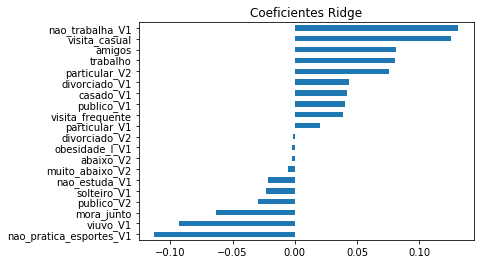

In [47]:
ridge_coefs = pd.Series(ridge.coef_, index = X_train.columns)


imp_ridge_coefs = pd.concat([ridge_coefs.sort_values().head(10),
                     ridge_coefs.sort_values().tail(10)])

imp_ridge_coefs.plot(kind = "barh")
plt.title("Coeficientes Ridge")
plt.show()

In [48]:
abs(ridge_coefs).sort_values(ascending=False)

nao_trabalha_V1            0.131556
visita_casual              0.125224
nao_pratica_esportes_V1    0.113115
viuvo_V1                   0.092891
amigos                     0.081048
trabalho                   0.080597
particular_V2              0.075595
mora_junto                 0.063306
divorciado_V1              0.043420
casado_V1                  0.042008
publico_V1                 0.040217
visita_frequente           0.039094
publico_V2                 0.029146
solteiro_V1                0.023154
nao_estuda_V1              0.021499
particular_V1              0.020411
menor_18_V2                0.018602
obsidade_III_V2            0.017436
18_24_anos_V2              0.015826
obesidade_II_V2            0.013389
25_34_anos_V2              0.013258
35_44_anos_V2              0.010964
obesidade_I_V2             0.009650
45_54_anos_V2              0.008139
muito_abaixo_V2            0.005575
55_64_anos_V2              0.005235
acima_V2                   0.004736
45_54_anos_V1              0

In [49]:
ridge_relevant_columns = ridge_coefs[ridge_coefs>=0.005575].index

ridge_X_train = X_train[ridge_relevant_columns]
ridge_X_test = X_test[ridge_relevant_columns]


In [50]:
%%time
relevant = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
relevant.fit(ridge_X_train, y_train)
alpha = relevant.alpha_
print("Melhor Alpha :", alpha)

print("Tentando de novo com valores de alpha centrados em " + str(alpha))
relevant = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
relevant.fit(ridge_X_train, y_train)
alpha = relevant.alpha_
print("Melhor Alpha :", alpha)


y_train_pred = relevant.predict(ridge_X_train)
y_test_pred = relevant.predict(ridge_X_test)


mean = mean_squared_error(y_test, y_test_pred) 
relevant_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
relevant_rmse

Melhor Alpha : 0.0001
Tentando de novo com valores de alpha centrados em 0.0001
Melhor Alpha : 6e-05
Wall time: 5.43 s


0.13134064774788765

Como podemos ver, essa tentativa não foi eficiente, visto que o RMSE foi maior do que a equação com todas as variáveis.

##### 5.2.2 Base Original com Feature Selection

Vamos utilizar o objeto SelectFromModel usando Lasso como argumento para fazer a seleção de variáveis.
Lasso tem o recurso matemático de zerar linhas que trazem informações de praticamente valor nenhum em relação a explicabilidade da variável target.

Vemos que o algoritmo de Ridge foi o vencedor mais uma vez, com o menor RMSE dentre os três.

In [51]:
num_original = (X_train.shape[1])
print('Número de Variáveis Original: {}'.format(num_original))

Número de Variáveis Original: 51


In [52]:
selector = SelectFromModel(LassoCV())
selector.fit(X_train, y_train)
selector.transform(X_train).shape

feature_idx = selector.get_support()
feature_name = X_train.columns[feature_idx]

In [53]:
num_novo = (selector.transform(X_train).shape[1])
print('Número de Variáveis Original: {}'.format(num_novo))

Número de Variáveis Original: 41


In [54]:
new_x_train = X_train[feature_name]
new_x_test = X_test[feature_name]

In [55]:
%%time
new_lr = LinearRegression()
new_lr.fit(new_x_train,y_train)
y_train_pred = new_lr.predict(new_x_train)
y_test_pred = new_lr.predict(new_x_test)


mean = mean_squared_error(y_test, y_test_pred) 
new_lr_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
new_lr_rmse

Wall time: 619 ms


0.11610013382220707

In [56]:
%%time

new_ridge = RidgeCV(alphas = [0.0001, 0.0003, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
new_ridge.fit(new_x_train, y_train)
alpha = new_ridge.alpha_
print("Melhor Alpha :", alpha)

print("Tentando de novo com valores de alpha centrados em " + str(alpha))
new_ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
new_ridge.fit(new_x_train, y_train)
alpha = new_ridge.alpha_
print("Melhor Alpha:", alpha)


y_train_pred = new_ridge.predict(new_x_train)
y_test_pred = new_ridge.predict(new_x_test)


mean = mean_squared_error(y_test, y_test_pred) 
new_ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
new_ridge_rmse

Melhor Alpha : 10.0
Tentando de novo com valores de alpha centrados em 10.0
Melhor Alpha: 14.0
Wall time: 45.5 s


0.11610010141634838

In [57]:
%%time
new_lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
new_lasso.fit(new_x_train, y_train)
alpha = new_lasso.alpha_
print("Melhor Alpha :", alpha)

print("Tentando de novo com valores de alpha centrados em " + str(alpha))
new_lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
new_lasso.fit(new_x_train, y_train)
alpha = new_lasso.alpha_
print("Melhor Alpha :", alpha)


y_train_pred = new_lasso.predict(new_x_train)
y_test_pred = new_lasso.predict(new_x_test)


mean = mean_squared_error(y_test, y_test_pred) 
new_lasso_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
new_lasso_rmse

Melhor Alpha : 0.0001
Tentando de novo com valores de alpha centrados em 0.0001
Melhor Alpha : 6e-05
Wall time: 11.5 s


0.11610624022634802

O algoritmo vencedor foi o Linear Regression da seção **5.2.1 Base Original** com o menor RMSE dentre todos.

Prosseguindo com a análise do modelo.

## 6. Interpretação
### 6.1 Análise dos Coeficientes

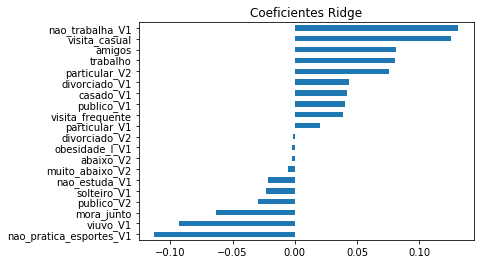

In [58]:
ridge_coefs = pd.Series(ridge.coef_, index = X_train.columns)


imp_ridge_coefs = pd.concat([ridge_coefs.sort_values().head(10),
                     ridge_coefs.sort_values().tail(10)])

imp_ridge_coefs.plot(kind = "barh")
plt.title("Coeficientes Ridge")
plt.show()

In [59]:
ridge_coefs.sort_values(ascending=False)

nao_trabalha_V1            0.131556
visita_casual              0.125224
amigos                     0.081048
trabalho                   0.080597
particular_V2              0.075595
divorciado_V1              0.043420
casado_V1                  0.042008
publico_V1                 0.040217
visita_frequente           0.039094
particular_V1              0.020411
menor_18_V2                0.018602
obsidade_III_V2            0.017436
18_24_anos_V2              0.015826
obesidade_II_V2            0.013389
25_34_anos_V2              0.013258
35_44_anos_V2              0.010964
obesidade_I_V2             0.009650
45_54_anos_V2              0.008139
55_64_anos_V2              0.005235
acima_V2                   0.004736
45_54_anos_V1              0.002965
18_24_anos_V1              0.002662
menor_18_V1                0.002355
25_34_anos_V1              0.001855
obsidade_III_V1            0.001722
55_64_anos_V1              0.001580
filhos_V1                  0.001134
sem_filhos_V1              0

In [60]:
ridge.intercept_

0.32815969976640735

**Interpretação:** 

O coeficiente do modelo é de 0.328. Ou seja, o valor esperado da transmissão de um indivíduo V1 qualquer para V2 é de 32.8% naturalmente (geralmente, dizemos que 32.8% é o valor esperado quando todos os outros preditores são igual a zero, mas nesse caso é impossível ter um IMC nulo por exemplo. Por conta disso, a constante não pode ser interpretada nesse problema utilizando essa linha de raciocínio).



Podemos ver também pelos coeficientes da equação que:

- O maior efeito de contaminação se dá quando V1 não trabalha. Ele tem um incremento de em média, 13,2% na probabilidade de transmissão para V2.

- O segundo efeito mais forte vai de encontro com a análise gráfica realizada anteriormente: Conexões por visitas casuais. Aqui, indivíduos conectados dessa forma tem uma probabilidade de contagio aumentada em média, 12,5%.

- Na contramão, o efeito que mais tem peso negativo na taxa de contágio é quando V1 não pratica esporte, com 11,3% em média. V2 tem uma chance quase desprezível de aumentar a chance de ser contaminado por V1 quando não pratica o mesmo.

- O terceiro efeito contrário, o qual diminui a probabilidade de contágio, é quando V1 mora junto a V2 (o que foi observado também na análise gráfica). Em média, V1 tende a ter uma redução na transmissão do virus de 6.3%.

- Também vemos mais uma constatação da análise gráfica onde conexões feitas por amigos e trabalho tem efeitos praticamente idênticos com aproximadamente 8%.

- Em relação a idade, verificamos que a idade de V2 é inversamente proporcional a taxa de contaminação. Ou seja, quanto mais jovem V2 for, mais propício ele se torna a adquirir o virus de V1. Isso contraria a hipótese de que o virus seria mais contagioso em idosos..

- Em relação a hipótese do transporte público, vemos que: Quando V1 utiliza o coletivo, aumenta em média a taxa de contágio para V2 em 4%. Em contrapartida, V2 quando usa o transporte, evita o contágio em quase 3%. É interessante ver que quando V2 utiliza transporte particular, em média ele agrava a taxa em 7.6%, sendo o quinto maior fator. Portanto, quando V1 utiliza um coletivo e V2, seu veículo próprio, as chances aumentam bastante.

### 6.2 Próximos Passos

Como funcionário da ONU, identifico diversos fatores que influenciam na taxa de contágio do vírus. Esses fatores levantam hipóteses e precisam ser validadas através de experimentos para retenção dessa taxa. Podemos agir seguindo alguns pontos:

- Investigar o comportamento de pessoas que não trabalham. Hipóteses levantadas podem ser sobre indivíduos que passam mais tempo fora de casa, panfletam currículos em varios locais diversos, aumentando suas chances de contrair o virus.

- Instigar o isolamento social para evitar o contágio e requerer medidas de distânciamento.

- Conscientizar a higiênização constante dos veículos de transporte, visto que a combinação destes podem agravar quem transmite e quem contrai.

- Conscientizar os jovens que é uma doença que tem mais risco a esse vírus.

### 7. Prevendo na Parcela Final da População.

In [61]:
case_data = connections[connections['prob_V1_V2'].isnull()]

In [62]:
case_data = case_data.merge(ind_V1, on='V1', how='left')
case_data = case_data.merge(ind_V2, on='V2', how='left')

Criando index para case_data. Como V2 é único dentro da base, este será nosso index.

In [63]:
case_data['V2'].nunique() == case_data.shape[0]
case_data.set_index('V2', inplace=True)

In [64]:
to_dummy = case_data.select_dtypes(include='object')
case_data = utils.one_hot_encoder(case_data, to_dummy)

In [65]:
to_drop_case_data = ['V1', 'prob_V1_V2', 'taxi_V1', 'taxi_V2',
            'familia', 'visita_rara', 
            'sem_info_filhos_V1','sem_info_filhos_V2',
            'sem_info_estado_civil_V1', 'sem_info_estado_civil_V2',
              'sem_info_estuda_V1', 'sem_info_estuda_V2',
              'sem_info_trabalha_V1', 'sem_info_trabalha_V2',
              'sem_info_pratica_esportes_V1', 'sem_info_pratica_esportes_V2',
              'sem_info_transporte_mais_utilizado_V1', 'sem_info_transporte_mais_utilizado_V2',
              'sem_info_filhos_V1', 'sem_info_filhos_V2', 
              'adequado_V1', 'adequado_V2', 'maior_65_V1', 'maior_65_V2'
             ]

case_data.drop(to_drop_case_data, axis=1, inplace=True)

Aplicando Ridge para estimação da taxa de contaminação para o restante da população.

In [66]:
final_predicted = ridge.predict(case_data) # Aplicando o modelo.
final_predicted = pd.DataFrame(pd.Series(final_predicted, index = case_data.index)).rename(columns={0: 'prob_V1_V2'}) # Montando Dataframe
final_predicted.to_csv('final_predicted.csv', header=False, sep=';')